In [7]:
# imports, declare necessary PATH variables

path_to_gurobi = r'C:/gurobi1200/win64' # Set to gurobi path in environment variables
import pulp as pl
import numpy as np
import pandas as pd
from gudhi.representations.preprocessing import BirthPersistenceTransform
from gudhi.representations.vector_methods import PersistenceImage
from gudhi.representations.vector_methods import Entropy
import networkx as nx
import math
import seaborn as sns
import time
import pysohar as oat
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})

In [2]:
# horz_timeseries = pd.read_csv('backstep-timeseries-geom/horz-timeseries.csv')
vert_timeseries_x_4H = pd.read_csv('backstep-timeseries-geom/vert-timeseries-x=4H.csv')
vert_timeseries_x_6H = pd.read_csv('backstep-timeseries-geom/vert-timeseries-x=6H.csv')
vert_timeseries_x_10H = pd.read_csv('backstep-timeseries-geom/vert-timeseries-x=10H.csv')
vert_timeseries_x_15H = pd.read_csv('backstep-timeseries-geom/vert-timeseries-x=15H.csv')

In [3]:
# horz_x_locs = horz_timeseries[' x_H'].drop_duplicates().tolist()
vert_z_locs = vert_timeseries_x_4H[' z_H'].drop_duplicates().tolist()

In [4]:
# horz_node_data = {}
# for loc in horz_x_locs:
#     horz_node_data[loc] = horz_timeseries.loc[horz_timeseries[' x_H'] == loc]
vert_x_4H_node_data = {}
vert_x_6H_node_data = {}
vert_x_10H_node_data = {}
vert_x_15H_node_data = {}
for loc in vert_z_locs:
    vert_x_4H_node_data[loc] = vert_timeseries_x_4H.loc[vert_timeseries_x_4H[' z_H'] == loc]
    vert_x_6H_node_data[loc] = vert_timeseries_x_6H.loc[vert_timeseries_x_6H[' z_H'] == loc]
    vert_x_10H_node_data[loc] = vert_timeseries_x_10H.loc[vert_timeseries_x_10H[' z_H'] == loc]
    vert_x_15H_node_data[loc] = vert_timeseries_x_15H.loc[vert_timeseries_x_15H[' z_H'] == loc]

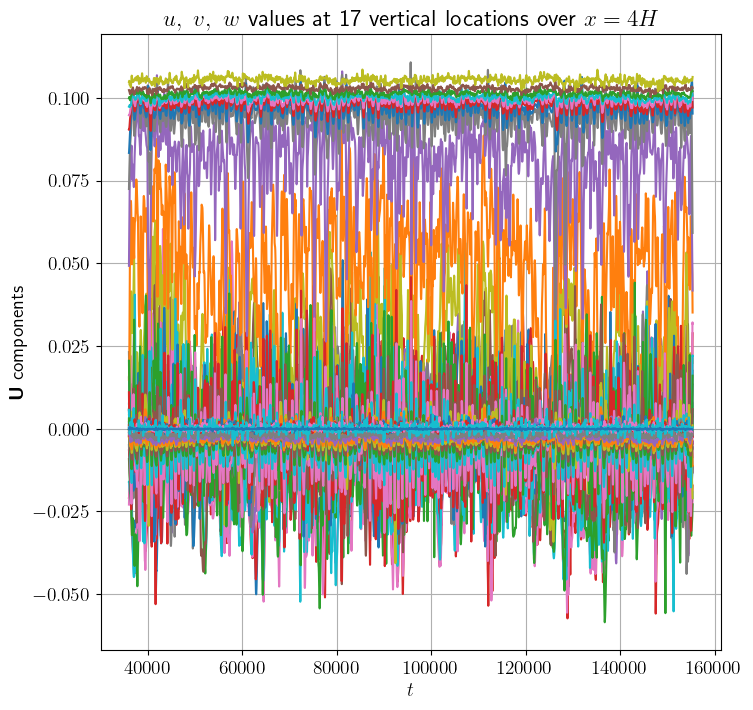

In [9]:
fig,ax = plt.subplots(figsize=(8,8))
ax.grid(visible=True)
t = np.array(vert_x_4H_node_data[vert_z_locs[0]]['t'].values.tolist())
for loc in vert_z_locs:
    ax.plot(t, vert_x_4H_node_data[loc][' u_ms'])
    ax.plot(t, vert_x_4H_node_data[loc][' v_ms'])
    ax.plot(t, vert_x_4H_node_data[loc][' w_ms'])

    # ax.plot(t, vert_x_6H_node_data[loc][' u_ms'])
    # ax.plot(t, vert_x_6H_node_data[loc][' v_ms'])
    # ax.plot(t, vert_x_6H_node_data[loc][' w_ms'])

    # ax.plot(t, vert_x_10H_node_data[loc][' u_ms'])
    # ax.plot(t, vert_x_10H_node_data[loc][' v_ms'])
    # ax.plot(t, vert_x_10H_node_data[loc][' w_ms'])

    # ax.plot(t, vert_x_15H_node_data[loc][' u_ms'])
    # ax.plot(t, vert_x_15H_node_data[loc][' v_ms'])
    # ax.plot(t, vert_x_15H_node_data[loc][' w_ms'])

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\textbf{U}$ components')
ax.set_title(r'$u,\ v,\ w$ values at 17 vertical locations over $x=4H$')

fig.savefig("LNSE_revisited/time_series.png",bbox_inches="tight", dpi = 250)

In [10]:
# use windows of 522 for 53 total snapshots
import itertools

# build the similarity matrix
def get_corr(series1,series2,comp1,comp2,times):
    m = len(times)
    mu_a, mu_b = 0, 0
    for time in times:
        mu_a += series1.loc[series1['t']==time][comp1].values[0]
        mu_b += series2.loc[series2['t']==time][comp2].values[0]
    mu_a, mu_b = mu_a / m, mu_b / m

    cov_ab = 0
    var_a, var_b = 0, 0
    for time in times:
        fac_a = (series1.loc[series1['t']==time][comp1].values[0] - mu_a)
        fac_b = (series2.loc[series2['t']==time][comp2].values[0] - mu_b)
        cov_ab += fac_a * fac_b
        var_a += fac_a ** 2
        var_b += fac_b ** 2
    
    cov_ab = cov_ab / (m-1)
    var_a = np.sqrt(var_a / (m-1))
    var_b = np.sqrt(var_b / (m-1))
    
    return cov_ab / (var_a * var_b)

def get_similarity_matrix(data,locs,comps,times):
    n = len(locs)
    sim_mat = np.zeros((3*n,3*n))
    var_perms = list(itertools.product(locs,comps))
    indices_set = list(itertools.product(var_perms,var_perms))
    indices_map = {}
    i = 0
    for perm in var_perms:
        indices_map[perm] = i
        i += 1
    for pair in indices_set:
        if pair[0] != pair[1]:
            i,j = indices_map[pair[0]], indices_map[pair[1]]
            sim_mat[i,j] = 1 - get_corr(data[pair[0][0]],data[pair[1][0]],pair[0][1],pair[1][1],times)
            
    max_entry = np.max(sim_mat)
    min_entry = np.min(sim_mat)

    return (sim_mat - min_entry) / (max_entry - min_entry)

In [11]:
# Get the PD timeseries

window = 522
for i in range(53):
    tstart , tend = i*522, (i+1)*522

    sim_mat = get_similarity_matrix(vert_x_4H_node_data,vert_z_locs[0:7],[' u_ms',' v_ms',' w_ms'],times=t[tstart:tend])
    factored = oat.rust.FactoredBoundaryMatrixVr(dissimilarity_matrix=sim_mat, dissimilarity_max=1.0,homology_dimension_max=3)
    homology = factored.homology()
    homology.to_csv('backstep-timeseries-geom/vert_timeseries_x_4H/win_' + str(i) + ".csv", index = False)

KeyboardInterrupt: 

In [163]:
# fig_pd = oat.plot.pd( homology )
# fig_pd.show()

In [12]:
# Centroids computation: K = 3, T = 100 iterations

def get_lifetimes(hxdx):
  """
  Generate an array of lifetimes as an nx2 array, where for each entry the first value is the birth and the second value is the death

  hxdx = (DataFrame) the homology information generated by FactoredBoundaryMatrixVr's (oat suite) homology method
          Columns should be "Time spent", "dimension", "birth", "death"
          Note: x in hxdx acts a placeholder for specific values, i.e. h1d2 (homology of diagram 1 dimension 2)
  """
  hxdx_list = np.column_stack((hxdx.birth.values.tolist(), hxdx.death.values.tolist()))
  hxdx_list[:,1][hxdx_list[:,1] == np.inf] = 1.00001

  bpt = BirthPersistenceTransform() # [x,y-x] transformation for weighting function

  return bpt(hxdx_list)

def linear_weight(arr):
    """
    Weight function weighting persistence image linearly along the y-axis
        
    arr = 1x2 array entry of birth persistence transformed persistence diagram
    """
    if type(arr) != type(np.array([])):
      raise TypeError("arr must have type np.array([])")
    return arr[1]

def get_X_bar(path,n):
  Di_dict = {}
  for i in range(n):
    Di_dict[i] = get_lifetimes(pd.read_csv(path + str(i) + ".csv"))
  
  X_bar_n = np.concatenate((Di_dict[0],Di_dict[1]))
  for i in range(2,n):
    X_bar_n = np.concatenate((X_bar_n,Di_dict[i]))

  return Di_dict, X_bar_n

def get_centroids(X_bar_n, k, T):
  # For analysis (can comment later)
  intermediate_centroids = []

  options = np.arange(len(X_bar_n))
  choices = np.random.choice(options,k,replace=False)
  c = X_bar_n[choices[0]]
  for i in range(1,len(choices)):
    c = np.vstack((c,X_bar_n[choices[i]]))
  intermediate_centroids.append(c)
  # Initialize clusters
  W = {}
  # Find clusters
  t, delta_c = 0, 100
  while (t < T) and delta_c > 1e-06:
    prior_c = c.copy()
    for j in range(k):
      W[j] = []
      for x in X_bar_n:
        min_dist = np.linalg.norm(x-c[j])
        for i in range(k):
          if i != j:
            if np.linalg.norm(x-c[i]) < min_dist:
              min_dist = np.inf
        if not np.isinf(min_dist):
          W[j].append(x)
    # Update centroids
    for j in range(k):
      if len(W[j]) != 0:
        num = 0
        den = 0
        for x in W[j]:
          num += linear_weight(x) * x
          den += linear_weight(x)
        c[j] = num / den
      else:
        choices = np.random.choice(options,1,replace=False)
        c[j] = X_bar_n[choices[0]]
    intermediate_centroids.append(c)
    delta_c = np.linalg.norm(prior_c - c)
  
  return c, intermediate_centroids


In [13]:
Di_dict, X_bar_n = get_X_bar(path='backstep-timeseries-geom/vert_timeseries_x_4H/win_',n=53) # Di_dict is the time series of PDs, bpt
c, intermediate_centroids = get_centroids(X_bar_n,k=4,T=100)

In [14]:
# get vector representations of each PD

def vectorize_PD(X_i,c,sigma):
    k = len(c)
    v = np.zeros((k))
    
    for j in range(k):
        for x in X_i:
            v[j] += linear_weight(x) * np.exp(-(np.linalg.norm(x - c[j]) / sigma[j])**2)
    
    return v


def get_V(Di_dict,c):
    V = {}
    k = len(c)
    Di_keys = Di_dict.keys()
    sigma = np.zeros((k))

    # Calculate the estimated radii/spread
    for j in range(k):
        min_dist = 100
        for l in range(k):
            if l != j:
                dist = np.linalg.norm(c[l]-c[j])
                if dist < min_dist:
                    min_dist = dist
        sigma[j] = min_dist / 2
    
    for key in Di_keys:
        Di = Di_dict[key]
        V[key] = vectorize_PD(Di,c,sigma)
    
    return V

In [15]:
V = get_V(Di_dict,c)

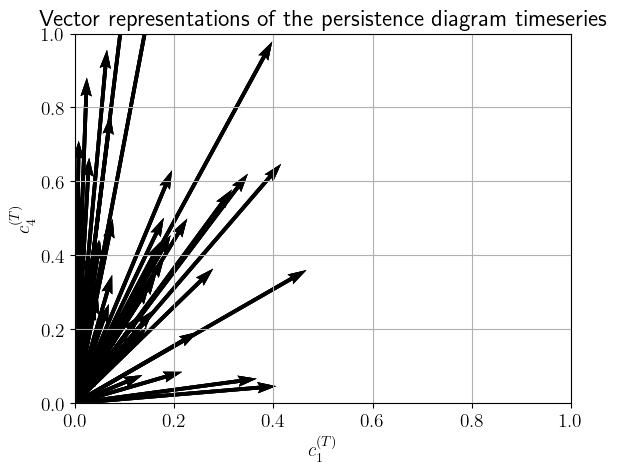

In [19]:
# Plot the vector representations of the persistence diagrams (in 2 components)

fig,ax = plt.subplots()
ax.grid(visible=True)

origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point

for key in V.keys():
    ax.quiver(*origin, V[key][0], V[key][3], color='black',scale=0.5)

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'$c_1^{(T)}$')
ax.set_ylabel(r'$c_4^{(T)}$')
ax.set_title('Vector representations of the persistence diagram timeseries')

fig.savefig("LNSE_revisited/vector_representations.png",bbox_inches="tight", dpi = 250)

In [20]:
# Based on V = {v1,...,vn}, build an anomoly detection test

mu = np.zeros((len(c)))
for key in V.keys():
    mu = mu + V[key]
mu = mu / len(V.keys())

Sigma = np.zeros((len(c),len(c)))
for key in V.keys():
    Sigma = Sigma + np.outer((V[key] - mu),(V[key] - mu))

def anomoly_score(v,mu,Sigma):
    """
    s^2(v) := (v-mu)^T Sigma^{-1} (v-mu)
    """
    return (v - mu) @ np.linalg.inv(Sigma) @ (v - mu)

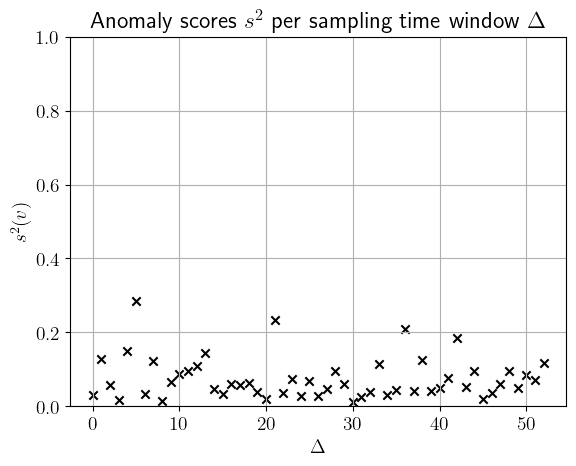

In [22]:
fig,ax = plt.subplots()
ax.grid(visible=True,which="both")

for win in V.keys():
    ax.scatter(win,anomoly_score(V[win],mu,Sigma),color='black',marker = "x")

ax.set_xlabel(r'$\Delta$')
ax.set_ylabel(r'$s^2(v)$')
ax.set_ylim([0,1])
ax.set_title(r'Anomaly scores $s^2$ per sampling time window $\Delta$')
fig.savefig("LNSE_revisited/test_data.png",bbox_inches="tight", dpi = 250)

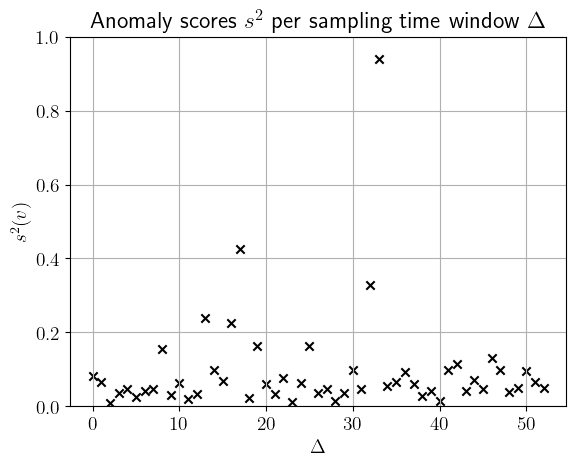

In [23]:
# Plot anomoly detection over x=6H data (downstream test data)

Di_dict, X_bar_n = get_X_bar(path='backstep-timeseries-geom/vert_timeseries_x_6H/win_',n=53)
V_test = get_V(Di_dict,c)

fig,ax = plt.subplots()
ax.grid(visible=True,which="both")

for win in V_test.keys():
    ax.scatter(win,anomoly_score(V_test[win],mu,Sigma),color='black',marker = "x")

ax.set_xlabel(r'$\Delta$')
ax.set_ylabel(r'$s^2(v)$')
ax.set_ylim([0,1])
ax.set_title(r'Anomaly scores $s^2$ per sampling time window $\Delta$')

fig.savefig("LNSE_revisited/training.png",bbox_inches="tight", dpi = 250)

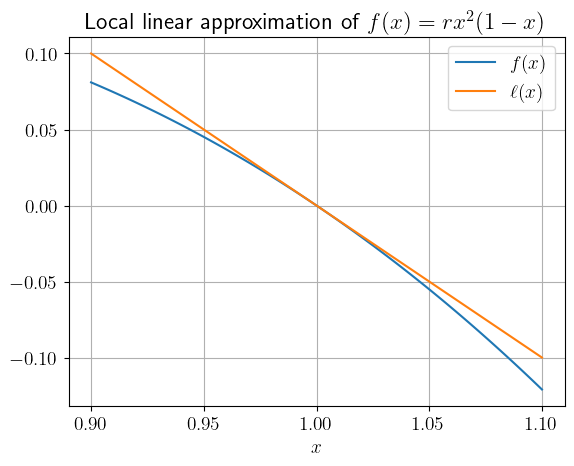

In [29]:
fig,ax = plt.subplots()
ax.grid(visible=True,which = 'both')

xx = np.linspace(0.9,1.1,100)
ax.plot(xx,xx**2 * (1-xx),label=r'$f(x)$')
ax.plot(xx,-xx+1,label=r'$\ell(x)$')

ax.legend()
ax.set_title(r'Local linear approximation of $f(x)=rx^2 (1-x)$')
ax.set_xlabel(r'$x$')
fig.savefig("LNSE_revisited/linear_approx.png",bbox_inches="tight", dpi = 250)